In [351]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
np.set_printoptions(precision=2, linewidth=120)
from copy import copy
from tqdm import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
PDIAG = np.zeros((9, 9))
for esi in np.eye(3):
    one = np.kron(esi, esi)
    PDIAG = PDIAG + np.outer(one, one)
PDIAG = PDIAG.astype(np.int)

def Ls(d=0.1):
    L1 = np.array([[np.cos(d), -np.sin(d), 0],
                   [np.sin(d), np.cos(d), 0],
                   [0, 0, 1]])
    L2 = np.roll(np.roll(L1, 1, axis=0), 1, axis=1)
    L3 = np.roll(np.roll(L2, 1, axis=0), 1, axis=1)
    return L1, L2, L3

def SENSOR(d=0.1):
    L1, L2, L3 = Ls(d)
    LL1 = np.dot(PDIAG, np.kron(L1, L1))
    LL2 = np.dot(PDIAG, np.kron(L2, L2))
    LL3 = np.dot(PDIAG, np.kron(L3, L3))
    SENSOR = np.r_[LL1[[0, 4, 8], :], LL2[[0, 4, 8], :], LL3[[0, 4, 8], :]]
    SENSOR = SENSOR[:, [0, 1, 2, 4, 5, 8]]
    return SENSOR

- Original basis `Q0`
- Recovered basis `Qc` (Controlled-bsais)
- Effected basis `Qeff = Qt.T * Q0`
- Use effected basis for error sampling
- Learn `Qt` progressively better
- When data comes in from the `Qeff` alignment, you must transform it back to the standard basis before average with the existing channel estimate

In [334]:
class Channel(object):
    def __init__(self, kx, ky, kz, **kwargs):
        self.kx, self.ky, self.kz = kx, ky, kz
        self.n = kwargs.get("n", 1e6)
        self.d = kwargs.get("d", 0.01)
        self.Q = kwargs.get("Q", np.eye(3))
        self.Qc = kwargs.get("Qc", np.eye(3))
        self.Mhat = kwargs.get("Mhat", np.zeros(3))
        self.cycle = 1
        self.C = np.dot(np.dot(channel.Q,
                               np.diag([channel.kx, channel.ky, channel.kz])),
                        channel.Q.T)
        self.Q = np.linalg.svd(self.C)[0]

    def sample_data(self):
        Cc = np.dot(np.dot(self.Qc, self.C), self.Qc.T)
        cvec = np.reshape(Cc, (9, 1))
        cvec = cvec[[0, 1, 2, 4, 5, 8], :]
        rates = np.dot(SENSOR(self.d), cvec).T[0]

        # Get samples for each L_i
        D1 = np.random.multinomial(self.n, rates[0:3]) / float(self.n)
        D2 = np.random.multinomial(self.n, rates[3:6]) / float(self.n)
        D3 = np.random.multinomial(self.n, rates[6:9]) / float(self.n)

        data = np.r_[D1, D2, D3]
        return data

    def update(self):
        # Get new data at this effective orientation
        data = self.sample_data()
        
        # Recover the process matrix at this orientation
        Mc = self.recoverM(data, self.d)
        Mnew = np.dot(np.dot(self.Qc.T, Mc), self.Qc)
        
        # Update Mhat in the standard basis
        self.Mhat = (self.cycle) / float(self.cycle+1) * self.Mhat \
                  + 1/float(self.cycle+1) * Mnew

        # Get the orientation that would diagonalize the full Mhat
        self.Qc = np.linalg.svd(self.Mhat)[0]

        # Update the process matrices
        self.cycle = self.cycle + 1

    @staticmethod
    def recoverM(data, d):
        # Linear constraint on trace
        # R * m = data
        # extend m by one variable x = [m; z1]
        # http://stanford.edu/class/ee103/lectures/constrained-least-squares/constrained-least-squares_slides.pdf
        TRACE = np.array([[1, 0, 0, 1, 0, 1]])
        R = np.r_[2.0 * np.dot(SENSOR(d).T, SENSOR(d)), TRACE]
        R = np.c_[R, np.r_[TRACE.T, [[0]]]]
        Y = np.r_[2.0*np.dot(SENSOR(d).T, data), 1]
        m = np.dot(np.dot(np.linalg.inv(np.dot(R.T, R)), R.T), Y)
        M = np.array([
                [m[0], m[1], m[2]],
                [m[1], m[3], m[4]],
                [m[2], m[4], m[5]]
            ])
        return M

Error x Time x Cycle_ratio

In [384]:
N_ERRORS = 1e14
N_CYCLES = np.logspace(0, 5, 40).astype(np.int)
RECORDS = []
for n_cycles in tqdm(N_CYCLES):
    n = int(N_ERRORS / n_cycles)
    channel = Channel(kx=0.7, ky=0.2, kz=0.1,
                      Q=np.linalg.qr(np.random.randn(3,3))[0],
                      n=n, d=0.01)

    RECORDS.append({
            "n_cycles": n_cycles,
            "time": 0,
            "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3))
        })
    for cycle in range(n_cycles):
        channel.update()
        RECORDS.append({
                "cycle_length": n,
                "n_cycles": n_cycles,
                "time": (cycle+1)*n,
                "Qdist": np.linalg.norm(np.dot(channel.Qc.T, channel.Q) - np.eye(3))
            })

df = pd.DataFrame(RECORDS)
df.to_csv("1e14errorsd0.01.csv")

In [393]:
df["cycle_length"] = (N_ERRORS / df["n_cycles"]).astype(np.int)

In [394]:
df

,Qdist,n_cycles,time,cycle_length
0,2.631324,1,0,100000000000000
1,0.000071,1,100000000000000,100000000000000
2,2.631324,1,0,100000000000000
3,0.000071,1,100000000000000,100000000000000
4,2.631324,1,0,100000000000000
5,0.000038,1,100000000000000,100000000000000
6,2.631324,2,0,50000000000000
7,0.000152,2,50000000000000,50000000000000
8,0.000060,2,100000000000000,50000000000000
9,2.631324,3,0,33333333333333


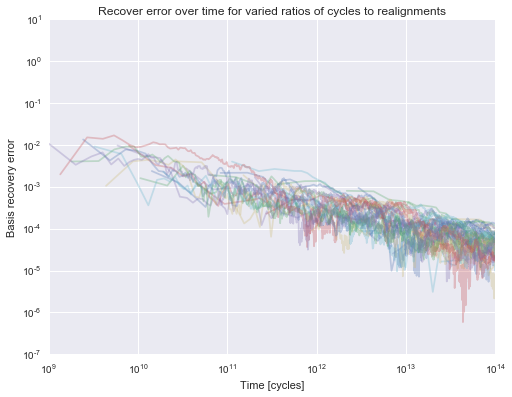

In [392]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for n_cycles in N_CYCLES:
    sel = (df["n_cycles"] == n_cycles)
    t = df.loc[sel, "time"]
    y = df.loc[sel, "Qdist"]
    ax.loglog(t, y, label=n_cycles, alpha=0.3)
plt.title("Recover error over time for varied ratios of cycles to realignments")
plt.xlabel("Time [cycles]")
plt.ylabel("Basis recovery error")